In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

In [3]:
this_run = Path('/data/users/tch14/completed_runs/88869')
print(f'looking in {this_run}')

datafiles = sorted([(int(f.stem), f) for f in this_run.iterdir() if f.name.endswith('npz') and not f.name == 'parameters.npz' and not f.name == 'aggregated.npz'])
jobs = np.array([j_id for j_id, f in datafiles])
#print([d.stem for i,d in datafiles])
print(f'job ids range from {min(jobs)} to {max(jobs)}')
print(f'missing jobs: {set(range(max(jobs))) - set(jobs)}')

looking in /data/users/tch14/completed_runs/88869
job ids range from 0 to 199
missing jobs: {68}


In [28]:
def aggregate(run_folder):
    datafiles = sorted([(int(f.stem), f) for f in run_folder.iterdir() if f.name.endswith('npz') and not f.name == 'parameters.npz' and not f.name == 'aggregated.npz'])
    
    data_slice = datafiles[:50]
    
    d0 = np.load(data_slice[0][1], allow_pickle = True)
    Ns = d0['Ns'][()]
    parameters = d0['parameters'][()]
    MCMC_params = d0['MCMC_params'][()]
    print(f'params: {parameters}')
    print(f'MCMC params: {MCMC_params}')
    
    l0 = d0['logs'][()][0]
    print('logs keys: ', [key for key in dir(l0) if not key.startswith('_')])

    N_betas = len(data_slice)
    N_steps = int(MCMC_params['N_steps'] / MCMC_params['thin'])
    N_Ns = Ns.shape[0]
    
    betas = np.zeros(shape = N_betas, dtype = np.float64)
    Fs = np.zeros(shape = (N_betas, N_Ns, N_steps), dtype = np.float64)
    Mf_moments = np.zeros(shape = (N_betas, N_Ns, l0.N_cumulants, N_steps), dtype = np.float64)
    
    for i, f in data_slice:
        if i % 10 == 0: print(f'Working on {i}-{i+10}')
        with np.load(f, allow_pickle = True) as d:
            logs = d['logs'][()]
            betas[i] = d['parameters'][()]['beta']
            for j, log in enumerate(logs):

                Fs[i, j, :] = log.Fc + log.Ff
                
                Mf_moments[i, j, :, :] = log.Mf_moments

    np.savez_compressed(run_folder / 'aggregated.npz',
            Ns = Ns, betas = betas, Ts = 1/betas, parameters = parameters, MCMC_params = MCMC_params,
            Mf_moments = Mf_moments,
            Fs = Fs,
            allow_pickle = True,
            desc = ''
            )
    
#aggregate(this_run)
print('Done!')

params: {'t': 1, 'alpha': 1.5, 'mu': 0, 'beta': 20.0, 'J': 5, 'U': 5, 'normalise': True, 'J_matrix': '...'}
MCMC params: {'state': '...', 'N_steps': 50000, 'N_burn_in': 1000, 'thin': 5, 'logger': <FKMC.montecarlo.Eigenspectrum_IPR_all object at 0x7f0fa0a188d0>, 'proposal': <function p_multi_site_uniform_reflect at 0x7f0fa22a89d8>, 'accept_function': <function perturbation_accept at 0x7f0fa22a8d08>, 'warnings': True}
logs keys:  ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'start', 'state', 'time', 'update']
Working on 0-10
Working on 10-20
Working on 20-30
Working on 30-40
Working on 40-50
Done!


In [4]:
%%time
data_agg = np.load(this_run / 'aggregated.npz', allow_pickle = True, mmap_mode = 'r')
Mf_moments = data_agg['Mf_moments']
Fs = data_agg['Fs']
Ts = data_agg['Ts']
Ns = data_agg['Ns']

CPU times: user 264 ms, sys: 40 ms, total: 304 ms
Wall time: 305 ms


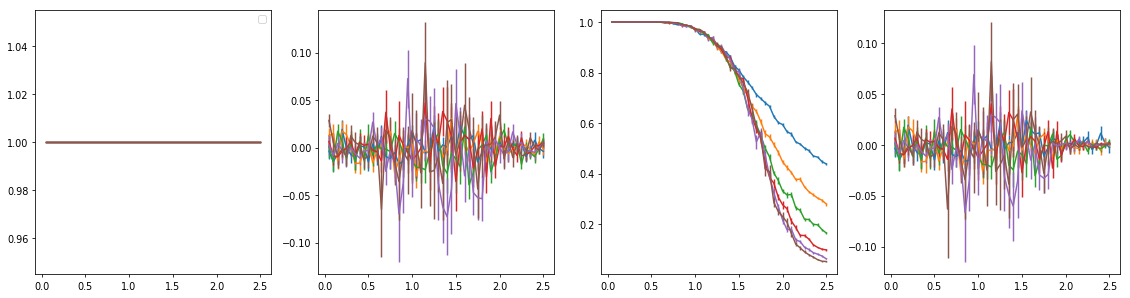

In [24]:
from FKMC.general import running_mean
from FKMC.stats import bin_std
f, axes = plt.subplots(1,4, figsize = (20,5))
#Mfs[beta, system_size, cumulant number, mc step]

for j in range(4):
    for i,N in enumerate(Ns):
            y = np.mean(Mf_moments[:, i, j], axis = -1)
            yerr = bin_std(Mf_moments[:, i, j], binsize = 500)
            axes[j].errorbar(Ts, y, yerr=yerr, linestyle = None)
axes[0].legend()
#axes[2].set(xlim = (0.5,1.5), ylim = (0.8,1.0))

In [27]:
def new_fs(new_betas, Fs, betas, fs, gs):
    #new_beta: the betas we want to interpolate to
    #betas: the set of temperatures at which the mcmc runs were performed
    #Fs.shape = (number of runs, number of step)
    #fs.shape = (number of runs), this need to be determined self consistently
    #final shapes: [new_beta index, runs over mcmc runs, runs over steps in an mcmc run, runs over runs again for innnermost sum]
    betas = betas[None, None, None, :]
    Fs3 = Fs[None, :, :]
    gs3 = gs[:]
    
    Fs4 = Fs[None, :, :, None]
    gs4 = gs[None, :, :, None]
    new_betas = new_betas[:, None, None]
    fs = fs[None, None, None, :]
    
    A = 1/gs3 * np.exp(- new_betas * Fs3) / np.sum(1/gs4 * np.exp(- betas * Fs4 + fs), axis = -1)
    expf = 1/Fs.shape[1] * np.sum(A, axis = (1,2))
    return - np.log(expf)
    
from scipy.optimize import fixed_point
def fit_fs(Fs, betas, fs_guess, gs):
    def func(fs): 
        if np.any(np.isnan(fs)): raise RuntimeError('The iteration hit a nan')
        return new_fs(betas, Fs, betas, fs, gs)
    fs = fixed_point(func, fs_guess, maxiter=1000)
    return fs

def FS_reweight(betas, beta, Fs, Os):
    exp_arg = -(betas[:, None] - beta) * Fs[None, :]
    #exp_arg -= np.max(exp_arg)
    
    boltz_factors = np.exp(exp_arg)
    return np.sum(boltz_factors * Os, axis = -1) / np.sum(boltz_factors, axis = -1)

def interp(Ts, Fs, Os, ax, **kwargs):
    for i in range(len(Ts))[1:-1]:
        new_Ts = np.linspace((Ts[i-1]+Ts[i])/2,(Ts[i+1]+Ts[i])/2, 20)

        reweighted_O = FS_reweight(betas = 1/new_Ts, beta = 1/Ts[i], Fs = Fs[i], Os = Os[i])

        ax.plot(new_Ts, reweighted_O, **kwargs)

def FS_multi_reweight(new_betas, Os, Fs, betas, fs_guess = None):
    #print(' '.join(f'{key} = {val.shape}' for key, val in locals().items()))
    print(Os.shape)
    gs = np.array([series_tau(x) for x in Os])
    fs_guess = fs_guess if not fs_guess is None else np.zeros_like(betas)
    fs = fit_fs(Fs, betas, fs_guess, gs)
    #print(fs)
    
    the_new_fs = new_fs(new_betas, Fs, betas, fs, gs)[:, None, None]
    new_betas = new_betas[:, None, None]
    gs3 = gs[:, None, None]
    Fs3 = Fs[None, :, :]

    
    betas = betas[None, None, None, :]
    fs = fs[None, None, None, :]
    gs4 = gs[None, None, None, :]
    Fs4 = Fs[None, :, :, None]

    
    O = 1/gs3 * Os * np.exp(- new_betas * Fs3 + the_new_fs) / np.sum(1/gs4 * np.exp(- betas * Fs4 + fs), axis = -1)
    
    return 1/Fs.shape[1] * np.sum(O, axis = (1,2)), fs[0,0,0,:]

def interp_multi(Ts, Fs, Os, ax, **kwargs):
    fs_guess = None
    for i in range(len(Ts))[2:-2]:
        try:
            ix = [i-2,i-1,i,i+1,i+2]
            new_Ts = np.linspace((Ts[i-1]+Ts[i])/2,(Ts[i]+Ts[i+1])/2, 20)

            reweighted_O, fs = FS_multi_reweight(new_betas = 1/new_Ts, betas = 1/Ts[ix], Fs = Fs[ix], Os = Os[ix])

            ax.plot(new_Ts, reweighted_O, **kwargs)
        except RuntimeError:
            pass

(5, 10000)


/home/tch14/FKMC/FKMC/stats.py:54: RuntimeWarning: divide by zero encountered in true_divide
  full = (lagged - np.mean(X)**2 ) / (np.mean(X**2) - np.mean(X)**2)
/home/tch14/FKMC/FKMC/stats.py:54: RuntimeWarning: invalid value encountered in true_divide
  full = (lagged - np.mean(X)**2 ) / (np.mean(X**2) - np.mean(X)**2)
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sign


IndexError: too many indices for array

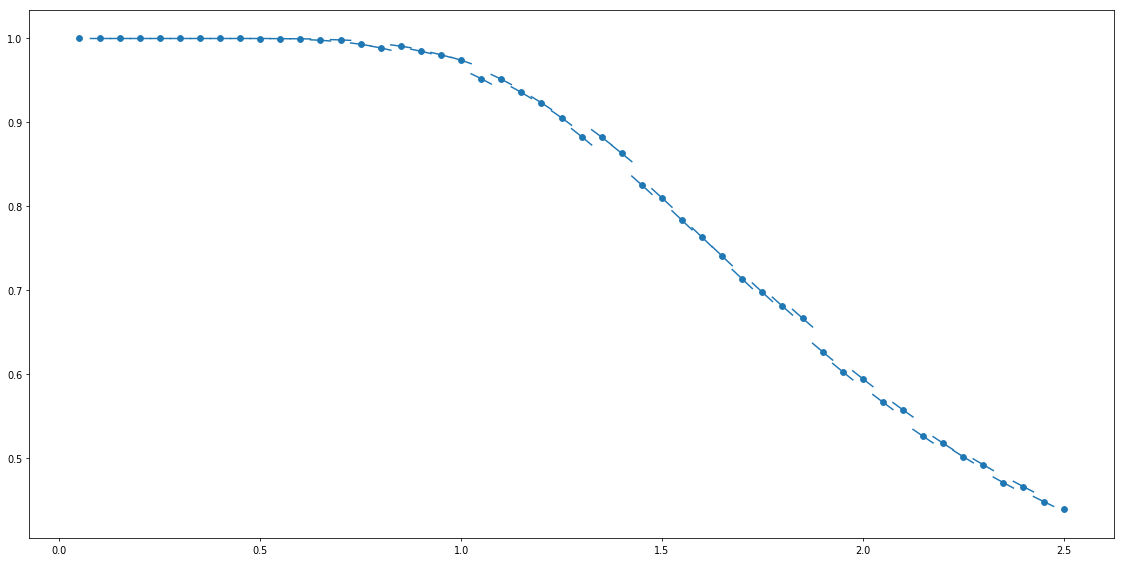

In [101]:
from FKMC.general import running_mean
f, ax = plt.subplots(1,1, figsize = (20,10))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i,N in enumerate(Ns):
        
            y = np.mean(Mf_moments[:, i, 2], axis = -1)
            yerr = np.std(Mf_moments[:, i, 2], axis = -1)
            
            ax.scatter(Ts, y, color = colors[i], label = f'N = {N}')
            
            interp(Ts, Fs[:, i], Mf_moments[:, i, 2], ax, color = colors[i])
            interp_multi(Ts, Fs[:, i], Mf_moments[:, i, 2], ax, color = colors[i])
ax.legend()
#ax.set(xlim = (1,1.5), ylim = (0.8,1.01))

T = 1.5499999999999998, N = 128


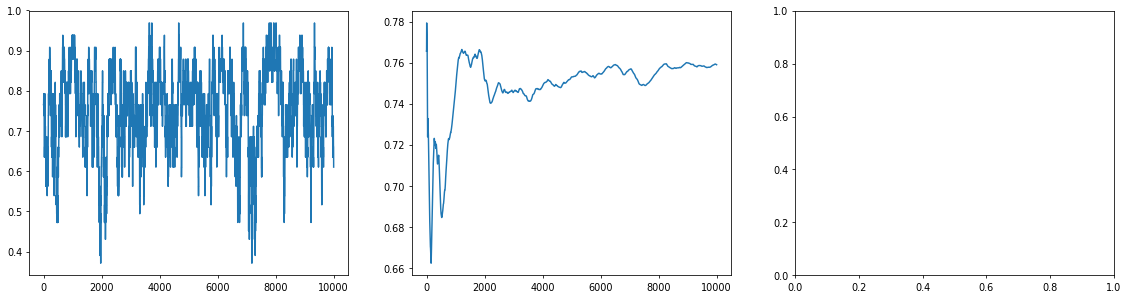

In [73]:
from FKMC.general import running_mean

i = 30
T = Ts[i]

j = 5
N = Ns[j]
print(f'T = {T}, N = {N}')

y = Mf_moments[i, j, 2]
f ,axes = plt.subplots(1,3, figsize = (20,5))
axes[0].plot(y)
axes[1].plot(running_mean(y))

## Looking at autocorrelations calculated using a series

[67.25333737]


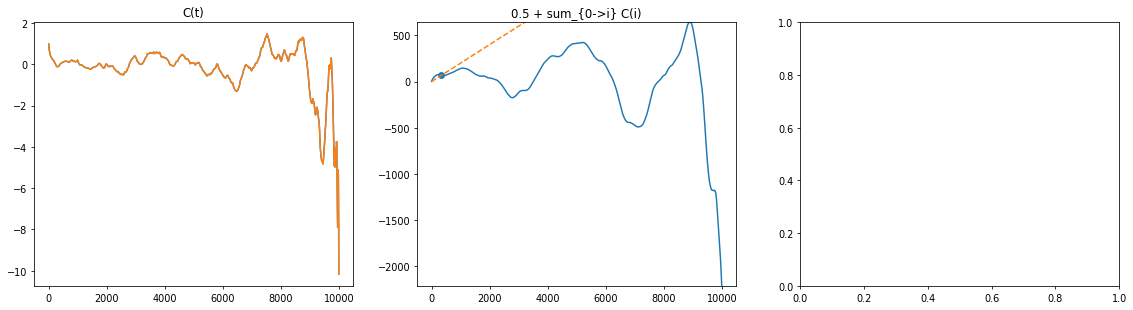

In [74]:
from FKMC.stats import autocorrelation

Cs = autocorrelation(y)
ts = np.arange(Cs.shape[0])

f ,axes = plt.subplots(1,3, figsize = (20,5))
axes[0].plot(ts, Cs)
axes[0].set(title = 'C(t)')
axes[0].plot(autocorrelation(y))

taus = 1/2 + np.cumsum(Cs)
axes[1].plot(ts, taus)
axes[1].set(title = '0.5 + sum_{0->i} C(i)', ylim = (min(taus), max(taus)))
axes[1].plot(ts,ts/5,'--')

crossings = np.argwhere(np.diff(np.sign(ts/5 - taus))).flatten()
axes[1].scatter(ts[crossings], taus[crossings])

def series_tau(X):
    Cs = autocorrelation(X)
    ts = np.arange(Cs.shape[0])
    taus = 1/2 + np.cumsum(Cs)
    
    crossings = np.argwhere(np.diff(np.sign(ts/5 - taus))).flatten()
    if len(crossings) != 1:
        return np.nan
    return taus[crossings]

print(series_tau(y))
    

## Looking at autocorrealtions calculated using binning

(10000,) (200,)
binsize = 50, tau = 49.444485310035176
binsize = 94, tau = 49.444485310035176
binsize = 152, tau = 49.444485310035176
binsize = 202, tau = 49.444485310035176
binsize = 236, tau = 49.444485310035176
binsize = 262, tau = 49.444485310035176
binsize = 273, tau = 49.444485310035176
binsize = 342, tau = 49.444485310035176
binsize = 247, tau = 49.444485310035176
binsize = 235, tau = 49.444485310035176


49.444485310035176

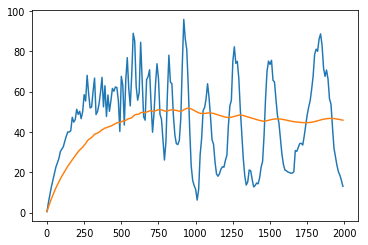

In [75]:
from FKMC.stats import bin_std
    
bins = np.arange(1,2000,10)
errs = np.array([bin_std(y, i) for i in bins])
sigma_naive = y.std()

taus = y.shape[0] / 2 * (errs / sigma_naive)**2

f ,ax = plt.subplots()
ax.plot(bins, taus)
print(y.shape, taus.shape)
ax.plot(bins, running_mean(taus))


estimate_tau(y, binsize = 50, max_its = 10, binsize_multiplier = 5)

[(0, 200)]

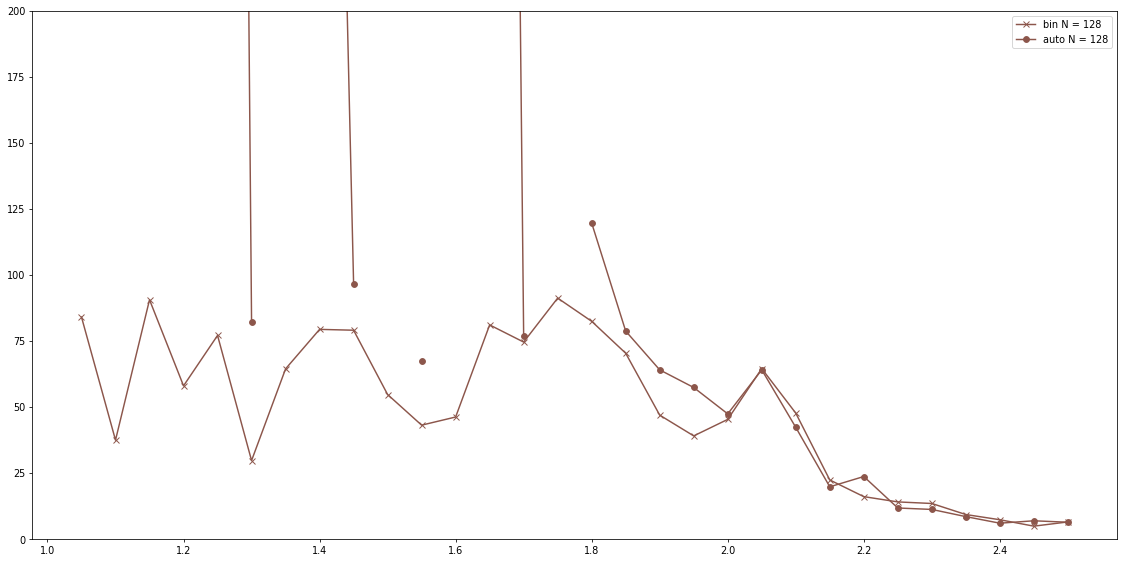

In [100]:
from FKMC.stats import bin_estimate_tau

f, ax = plt.subplots(1,1, figsize = (20,10))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

idx = np.where(Ts > 1)

for i,N in enumerate(Ns):
    if N != 128: continue
    y_ = Mf_moments[idx, i, 2]
    auto_taus = np.array([series_tau(x) for x in y_[0]])
    bin_taus = bin_estimate_tau(y_)

    ax.plot(Ts[idx], bin_taus[0], color = colors[i], label = f'bin N = {N}', marker = 'x')
    ax.plot(Ts[idx], auto_taus, color = colors[i], label = f'auto N = {N}', marker = 'o')
ax.legend()
ax.set(ylim = (0,200))

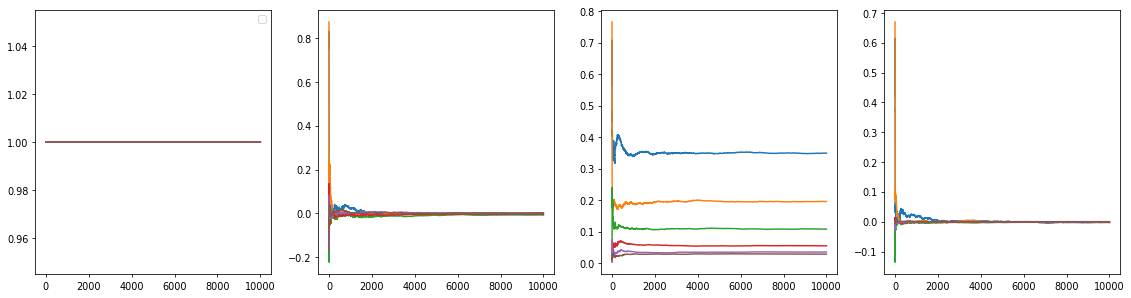

In [21]:
from FKMC.general import running_mean
f, axes = plt.subplots(1,4, figsize = (20,5))
x = np.arange(log.N_steps)

for j in range(4):
    for i,N in enumerate(Ns):
            log = logs[i]
            y = running_mean(log.Mf_moments[j])
            axes[j].plot(x, y)
axes[0].legend()

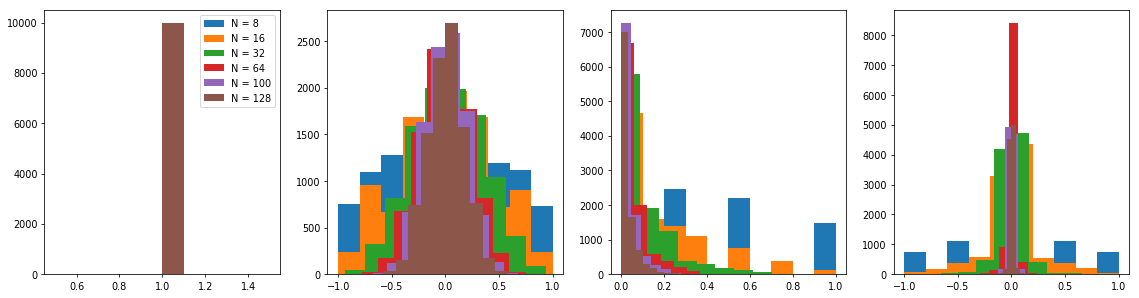

In [34]:
from FKMC.general import running_mean
f, axes = plt.subplots(1,4, figsize = (20,5))
x = np.arange(log.N_steps)

for j in range(4):
    for i,N in enumerate(Ns):
            log = logs[i]
            y = log.Mf_moments[j]
            axes[j].hist(y, label = f'N = {N}')
axes[0].legend()

In [ ]:
from FKMC.general import running_mean
f, axes = plt.subplots(1,4, figsize = (20,5))
x = np.arange(log.N_steps)

for j in range(4):
    for i,N in enumerate(Ns):
            log = logs[i]
            y = running_mean(log.Mf_moments[j])
            axes[j].plot(x, y)
axes[0].legend()

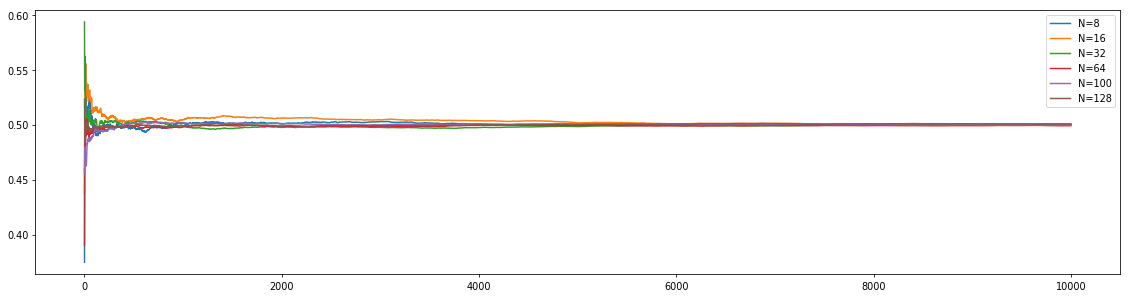

In [24]:
from FKMC.general import running_mean
f, ax = plt.subplots(1,1, figsize = (20,5))
x = np.arange(log.N_steps)

for i,N in enumerate(Ns):
        log = logs[i]
        y = running_mean(np.mean(log.state, axis = -1))
        ax.plot(x, y, label = f'N={N}')
ax.legend()

In [31]:
log = logs[-3]
N = Ns[-3]
print(f"System size = {N}, steps = {log.N_steps}, thin = {d['MCMC_params'][()]['thin']}")
print(f'mean(M^2) = {np.mean(log.Mf_moments[2])}')
print(f'std(M^2) = {np.std(log.Mf_moments[2])}')
      


System size = 64, steps = 10000, thin = 5
mean(M^2) = 0.0558021484375
std(M^2) = 0.0730121714102116


In [ ]:
from zipfile import BadZipfile
zips = []
data = []
for n,file in datafiles:
    try:
        z = np.load(file, allow_pickle = True)
        d = z['logs'][()]
        zips.append(z)
        data.append(d)
    except (BadZipfile, OSError):
        print(f'{file.name} is corrupted')

In [48]:
f'{sum([log.time for log in data]) / (60*60):.0f} hours total'

'219 hours total'

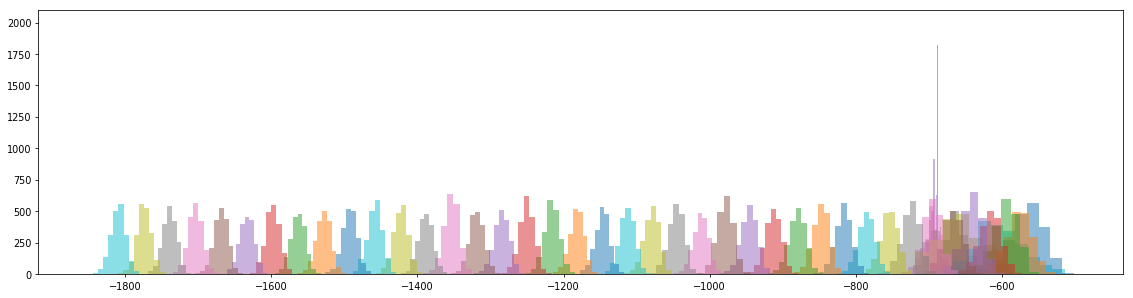

In [50]:
Ts = parameters['Ts']
assert(len(data) == len(Ts))

f, ax = plt.subplots(1, figsize = (20,5))
for T, d in zip(Ts,data):
    F = d.Ff + d.Fc
    #print(f'T = {T}, F.mean() = {F.mean()}')
    ax.hist(F, label = T, alpha = 0.5)
#ax.legend()

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


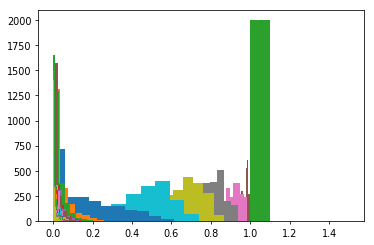

In [12]:
f, ax = plt.subplots(1)
for T, d in zip(Ts,data):
    ax.hist(d.Mf_moments[2], label = T)
#ax.legend()

<ErrorbarContainer object of 3 artists>

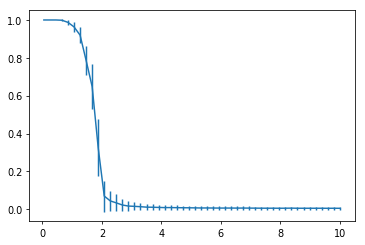

In [51]:
y = np.array([log.Mf_moments[2].mean() for log in data])
yerr = np.array([log.Mf_moments[2].std() for log in data]) 
x = Ts

f, ax = plt.subplots(1)
ax.errorbar(x, y, yerr = yerr)


In [68]:
def new_fs(new_betas, Fs, betas, fs):
    #new_beta: the betas we want to interpolate to
    #betas: the set of temperatures at which the mcmc runs were performed
    #Fs.shape = (number of runs, number of step)
    #fs.shape = (number of runs), this need to be determined self consistently
    #final shapes: [new_beta index, runs over mcmc runs, runs over steps in an mcmc run, runs over runs again for innnermost sum]
    betas = betas[None, None, None, :]
    Fs3 = Fs[None, :, :]
    Fs4 = Fs[None, :, :, None]
    new_betas = new_betas[:, None, None]
    fs = fs[None, None, None, :]
    
    A = np.exp(- new_betas * Fs3) / np.sum(np.exp(- betas * Fs4 + fs), axis = -1)
    expf = 1/Fs.shape[1] * np.sum(A, axis = (1,2))
    return - np.log(expf)
    
from scipy.optimize import fixed_point
def fit_fs(Fs, betas, fs_guess):
    def func(fs): 
        if np.any(np.isnan(fs)): raise RuntimeError('The iteration hit a nan')
        return new_fs(betas, Fs, betas, fs)
    fs = fixed_point(func, fs_guess, maxiter=1000)
    return fs
    

Fs = np.array([log.Ff + log.Fc for log in data])
O = np.array([log.Mf_moments[2] for log in data])
Ts = parameters['Ts']

y = O.mean(axis = -1)
yerr = O.std(axis = -1)



f, ax = plt.subplots(1, figsize = (15,5))
ax.scatter(Ts, y, marker = 'o')
ax.set(
    title = 'FS reweight single point',
    xlim = (0.5,4),
    )
        
interp(Ts, Fs, Os, ax)

def FS_multi_reweight(new_betas, Os, Fs, betas, fs_guess = None):
    #print(' '.join(f'{key} = {val.shape}' for key, val in locals().items()))
    fs_guess = fs_guess if not fs_guess is None else np.zeros_like(betas)
    fs = fit_fs(Fs, betas, fs_guess)
    print(fs)
    
    the_new_fs = new_fs(new_betas, Fs, betas, fs)[:, None, None]
    new_betas = new_betas[:, None, None]
    Fs3 = Fs[None, :, :]
    
    betas = betas[None, None, None, :]
    fs = fs[None, None, None, :]
    Fs4 = Fs[None, :, :, None]
    
    O = Os * np.exp(- new_betas * Fs3 + the_new_fs) / np.sum(np.exp(- betas * Fs4 + fs), axis = -1)
    
    return 1/Fs.shape[1] * np.sum(O, axis = (1,2)), fs[0,0,0,:]

def interp_multi(Ts, Fs, Os, ax):
    fs_guess = None
    for i in range(len(Ts))[3:-5]:
        try:
            ix = [i-1,i,i+1]
            new_Ts = np.linspace((Ts[i-1]+Ts[i])/2,(Ts[i]+Ts[i+1])/2, 20)

            reweighted_O, fs = FS_multi_reweight(new_betas = 1/new_Ts, betas = 1/Ts[ix], Fs = Fs[ix], Os = O[ix])

            ax.plot(new_Ts, reweighted_O, color = 'r')
        except RuntimeError:
            pass
                             
interp_multi(Ts, Fs, Os, ax)

NameError: name 'data' is not defined

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


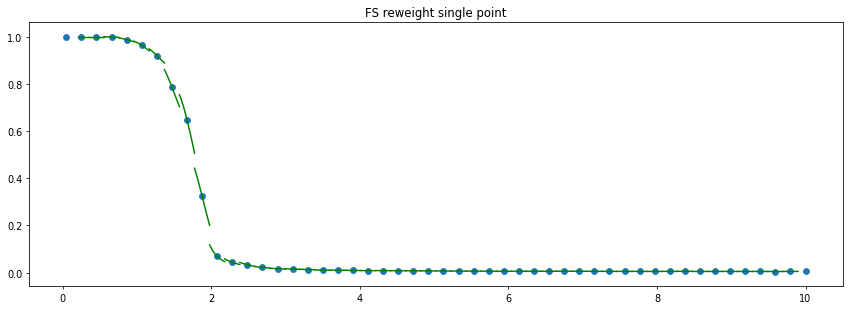

In [209]:
def FS_reweight(betas, beta, Fs, Os):
    exp_arg = -(betas[:, None] - beta) * Fs[None, :]
    #exp_arg -= np.max(exp_arg)
    
    boltz_factors = np.exp(exp_arg)
    return np.sum(boltz_factors * Os, axis = -1) / np.sum(boltz_factors, axis = -1)

def interp(Ts, Fs, Os, ax):
    for i in range(len(Ts))[1:-1]:
        new_Ts = np.linspace((Ts[i-1]+Ts[i])/2,(Ts[i+1]+Ts[i])/2, 20)

        reweighted_O = FS_reweight(betas = 1/new_Ts, beta = 1/Ts[i], Fs = Fs[i], Os = O[i])

        ax.plot(new_Ts, reweighted_O, color = 'g')

Fs = np.array([log.Ff + log.Fc for log in data])
O = np.array([log.Mf_moments[2] for log in data])

y = O.mean(axis = -1)
yerr = O.std(axis = -1)

Ts = parameters['Ts']

f, ax = plt.subplots(1, figsize = (15,5))
ax.scatter(Ts, y, marker = 'o')
ax.set(
    title = 'FS reweight single point',
    #xlim = (1,3),
    )
        
interp(Ts, Fs, Os, ax)

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: underflow encountered in multiply
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


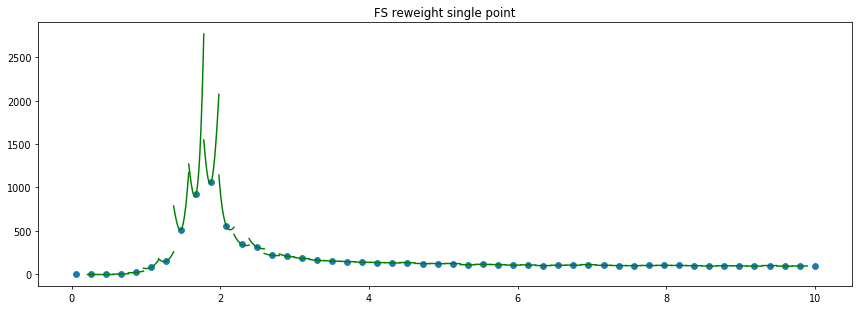

In [208]:
Fs = np.array([log.Ff + log.Fc for log in data])
O = (Fs - Fs.mean(axis=-1)[:, None])**2

y = O.mean(axis = -1)
yerr = O.std(axis = -1)

Ts = parameters['Ts']

f, ax = plt.subplots(1, figsize = (15,5))
ax.scatter(Ts, y, marker = 'o')
ax.set(
    title = 'FS reweight single point',
    #xlim = (1,3),
    )
        
interp(Ts, Fs, Os, ax)

/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/tch14/conda-envs/intelpython3.5/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


single point rewighting done


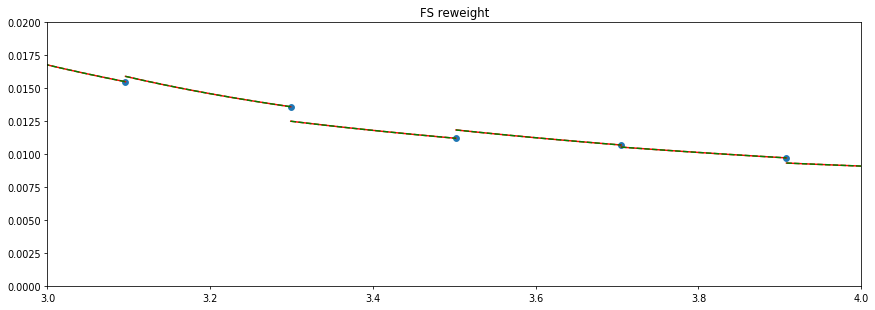

In [187]:
y = np.array([log.Mf_moments[2].mean() for log in data])
yerr = np.array([log.Mf_moments[2].std() for log in data]) 
x = Ts = parameters['Ts']

f, ax = plt.subplots(1, figsize = (15,5))
ax.scatter(x, y, marker = 'o')
ax.set(
    title = 'FS reweight',
    xlim = (3,4),
    ylim = (0,0.02)
    )

def FS_reweight_two_point(betas, beta, Fs, Os):
    beta, Fs, Os = np.broadcast_arrays(beta[:, None], Fs, Os)
    #beta = beta[:, None] * np.ones(Fs.shape)[None, :]
    beta, Fs, Os = np.array([beta, Fs, Os]).reshape(3,-1)
    
    exp_arg = -(betas[:, None] - beta[None, :]) * Fs[None, :]
    #exp_arg -= np.max(exp_arg)
    
    boltz_factors = np.exp(exp_arg)
    return np.sum(boltz_factors * Os, axis = -1) / np.sum(boltz_factors, axis = -1)

for i in range(len(data))[1:-1]:
    new_Ts = np.linspace(x[i-1],x[i], 20)
    #new_Ts = np.array([x[i],])

    betas = 1/new_Ts
    Fs = data[i].Ff + data[i].Fc
    Os = data[i].Mf_moments[2]

    reweighted_O = FS_reweight(betas, 1/x[i], Fs, Os)
    ax.plot(new_Ts, reweighted_O, color = 'r')
print('single point rewighting done')
    
for i in range(len(data))[1:-1]:
    new_Ts = np.linspace(x[i-1],x[i], 10)
    betas = 1/new_Ts
    
    beta = np.array([1/Ts[i-1], 1/Ts[i]])
    Fs = np.array([data[i-1].Ff + data[i-1].Fc, data[i].Ff + data[i].Fc])
    Os = np.array([data[i-1].Mf_moments[2], data[i].Mf_moments[2]])

    reweighted_O = FS_reweight_two_point(betas, beta, Fs, Os)
    ax.plot(new_Ts, reweighted_O, '--g')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


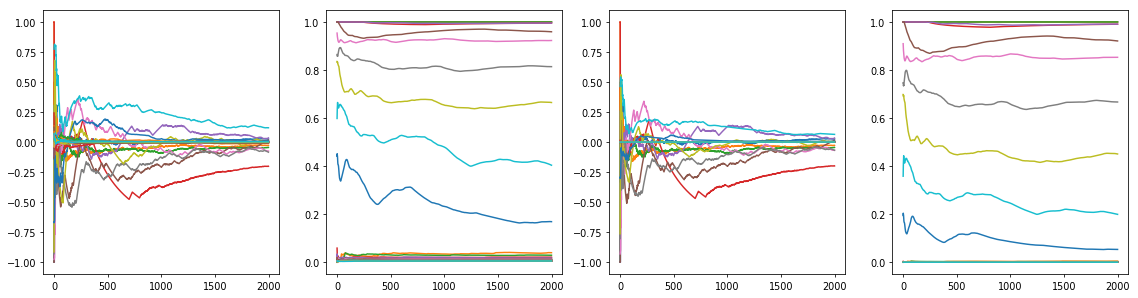

In [122]:
from FKMC.general import running_mean
f, axes = plt.subplots(1,4, figsize = (20,5))
for j in range(4):
    for i in range(len(Ts)):
        T = Ts[i]
        log = data[i]
        y = running_mean(log.Mf_moments[j+1])
        axes[j].plot(y)
ax.legend()

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


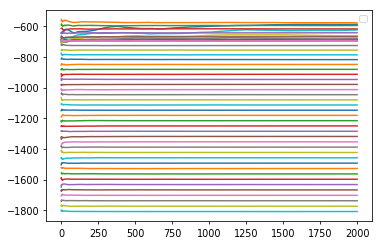

In [91]:
from FKMC.general import running_mean
f, ax = plt.subplots(1)
for i in range(len(Ts)):
    T = Ts[i]
    log = data[i]
    y = running_mean(log.Ff + log.Fc)
    x = np.arange(len(y))
    ax.errorbar(x, y)
ax.legend()

T = 1.4714285714285713


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


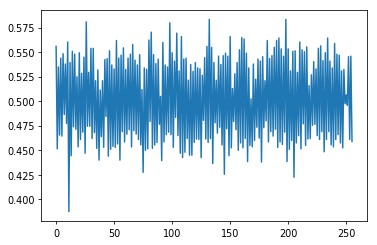

In [127]:
i = 7
f, ax = plt.subplots(1)
T = Ts[i]
print(f'T = {T}')
log = data[i]

#average site occupations
A = 2*(np.arange(log.N_sites) % 2) - 1
plt.plot(log.state.mean(axis = 0))

In [21]:
n_by_ns = np.zeros((50,256,256))
corrs = np.zeros((50,256,256))
cs = np.zeros((50,256))

A = 2*(np.arange(log.N_sites) % 2) - 1
for i in range(50):
    log = data[i]
    t = A * (2*log.state - 1)
    n_by_ns[i] = np.mean(t[:, :, None] * t[:, None, :], axis = 0)

    for j in range(log.N_sites):
        corrs[i,j] = np.roll(n_by_ns[i,j], shift = -j, axis = 0)

    cs[i] = corrs[i].mean(axis = 0)

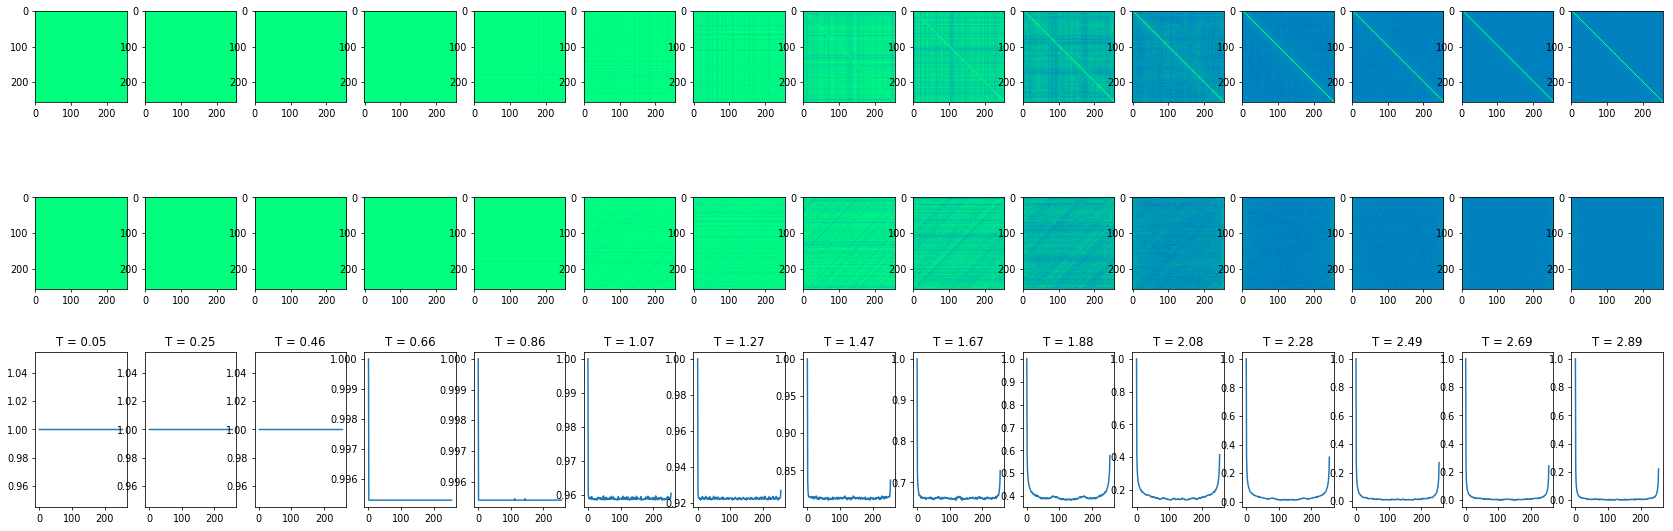

In [23]:
Is = np.arange(15)
f, axes = plt.subplots(3,len(Is), figsize = (,10))
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
cmap = plt.cm.get_cmap("winter")
for ax, i in zip(axes.T, Is):
    T = Ts[i]
    log = data[i]

    ax[2].set(title = f'T = {T:.2f}')
    ax[0].imshow(n_by_ns[i], cmap = cmap, norm = norm)
    ax[1].imshow(corrs[i], cmap = cmap, norm = norm)
    ax[2].plot(cs[i])